In [ ]:
import numpy as np
import pandas as pd
import csv
import numpy as np
import warnings
warnings.filterwarnings("ignore") #suppress warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from google.colab import drive
drive.mount('/content/drive')
headers =  ['age', 'sex','chest_pain','resting_blood_pressure',  
        'serum_cholestoral', 'fasting_blood_sugar', 'resting_ecg_results',
        'max_heart_rate_achieved', 'exercise_induced_angina', 'oldpeak',"slope of the peak",
        'num_of_major_vessels','thal', 'heart_disease']
heart_df = pd.read_csv('/content/drive/My Drive/EECS738/heart.dat', sep=' ', names=headers)


Mounted at /content/drive


In [ ]:
#show data
heart_df.head()
heart_df.shape

(270, 14)

data prep

In [ ]:
#binary class data case
#convert input as np.array
X = heart_df.drop(columns=['heart_disease'])
#replace target class with 0 and 1 
#1 means "have heart disease" and 0 means "do not have heart disease"
heart_df['heart_disease'] = heart_df['heart_disease'].replace(1, 0)
heart_df['heart_disease'] = heart_df['heart_disease'].replace(2, 1)

y_label = heart_df['heart_disease'].values.reshape(X.shape[0], 1)

#split data into train and test set
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y_label, test_size=0.2, random_state=2)

#standardize the dataset
sc = StandardScaler()
sc.fit(Xtrain)
Xtrain = sc.transform(Xtrain)
Xtest = sc.transform(Xtest)

show data strut

In [ ]:
heart_df.head()

,age,sex,chest_pain,resting_blood_pressure,serum_cholestoral,fasting_blood_sugar,resting_ecg_results,max_heart_rate_achieved,exercise_induced_angina,oldpeak,slope of the peak,num_of_major_vessels,thal,heart_disease
0,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0,1
1,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0,0
2,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0,1
3,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0,0
4,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0,0


In [ ]:
print(f"Shape of train set is {Xtrain.shape}")
print(f"Shape of test set is {Xtest.shape}")
print(f"Shape of train label is {ytrain.shape}")
print(f"Shape of test labels is {ytest.shape}")

Shape of train set is (216, 13)
Shape of test set is (54, 13)
Shape of train label is (216, 1)
Shape of test labels is (54, 1)


activation func

In [ ]:
def ReLu(x):
  return np.maximum(0.0, x)

def dReLu(x):
  x[x<=0] = 0
  x[x>0] = 1
  return x

def sigmoid(Z):
  '''
  The sigmoid function takes in real numbers in any range and 
  squashes it to a real-valued output between 0 and 1.
  '''
  return 1/(1+np.exp(-Z))

def dsigmoid(Z):
  sig = sigmoid(Z);
  return sig * (1.0 - sig);  

NN structure

In [ ]:
class NN():

  def __init__(self, layers=[13,8,1], learning_rate=0.001, iterations=100):
    self.params = {}
    self.learning_rate = learning_rate
    self.iterations = iterations
    self.loss = []
    self.sample_size = None
    self.layers = layers
    self.X = None
    self.y = None

  def init_weights(self):
    np.random.seed(1) # Seed the random number generator
    self.params["W1"] = np.random.randn(self.layers[0],self.layers[1]) 
    self.params['b1'] = np.random.randn(self.layers[1],)
    self.params['W2'] = np.random.randn(self.layers[1],self.layers[2]) 
    self.params['b2'] = np.random.randn(self.layers[2],)
 
  
  def eta(self, x):
    ETA = 0.0000000001
    return np.maximum(x, ETA)

  def entropy_loss(self,y, yhat):
    nsample = len(y)
    yhat_inv = 1.0 - yhat
    y_inv = 1.0 - y
    yhat = self.eta(yhat) ## clips value to avoid NaNs in log
    yhat_inv = self.eta(yhat_inv) 
    loss = -1/nsample * (np.sum(np.multiply(np.log(yhat), y) + np.multiply((y_inv), np.log(yhat_inv))))
    return loss
  
  def ReLu(self,Z):
    return np.maximum(0.0, Z)

  def dReLu(self,x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

  def sigmoid(self,Z):
    '''
    The sigmoid function takes in real numbers in any range and 
    squashes it to a real-valued output between 0 and 1.
    '''
    return 1/(1+np.exp(-Z))

  def dsigmoid(self,Z):
    sig = sigmoid(Z);
    return sig * (1.0 - sig); 

  def forward(self):
    # self.layer = ReLu(np.dot(self.input, self.weights1))
    # self.output = ReLu(np.dot(self.layer, self.weights2))
    Z1 = self.X.dot(self.params['W1']) + self.params['b1']
    A1 = self.ReLu(Z1)
    Z2 = A1.dot(self.params['W2']) + self.params['b2']
    yhat = self.sigmoid(Z2)
    loss = self.entropy_loss(self.y,yhat)

    # save calculated parameters in dictionary    
    self.params['Z1'] = Z1
    self.params['Z2'] = Z2
    self.params['A1'] = A1

    return yhat,loss

  def backward(self, yhat):
    '''
    Computes the derivatives and update weights and bias according.
    '''
    y_inv = 1 - self.y
    yhat_inv = 1 - yhat
    
    # the loss with respect to
    dl_wrt_yhat = np.divide(y_inv, self.eta(yhat_inv)) - np.divide(self.y, self.eta(yhat))
    dl_wrt_sig = yhat * (yhat_inv)
    dl_wrt_z2 = dl_wrt_yhat * dl_wrt_sig

    dl_wrt_A1 = dl_wrt_z2.dot(self.params['W2'].T)
    dl_wrt_w2 = self.params['A1'].T.dot(dl_wrt_z2)
    dl_wrt_b2 = np.sum(dl_wrt_z2, axis=0, keepdims=True)

    dl_wrt_z1 = dl_wrt_A1 * self.dReLu(self.params['Z1'])
    dl_wrt_w1 = self.X.T.dot(dl_wrt_z1)
    dl_wrt_b1 = np.sum(dl_wrt_z1, axis=0, keepdims=True)

    #update the weights and bias
    self.params['W1'] = self.params['W1'] - self.learning_rate * dl_wrt_w1
    self.params['W2'] = self.params['W2'] - self.learning_rate * dl_wrt_w2
    self.params['b1'] = self.params['b1'] - self.learning_rate * dl_wrt_b1
    self.params['b2'] = self.params['b2'] - self.learning_rate * dl_wrt_b2

  def fit(self, X, y):
    '''
    Trains the neural network using the specified data and labels in iteration
    '''
    self.X = X
    self.y = y
    self.init_weights() #initialize weights and bias

    for i in range(self.iterations):
        yhat, loss = self.forward()
        self.backward(yhat)
        self.loss.append(loss)
  
  def predict(self, X):
    '''
    Predicts on a test data
    '''
    Z1 = X.dot(self.params['W1']) + self.params['b1']
    A1 = self.ReLu(Z1)
    Z2 = A1.dot(self.params['W2']) + self.params['b2']
    pred = self.sigmoid(Z2)
    return np.round(pred)  

  def cal_acc(self,y,yhat):
    '''
    Calculates the accutacy between the predicted valuea and the truth labels
    '''
    acc = int(sum(y == yhat) / len(y) * 100)
    return acc    

  def plot_loss(self):
    '''
    Plots the loss curve
    '''
    plt.plot(self.loss)
    plt.xlabel("Iteration")
    plt.ylabel("logloss")
    plt.title("Loss curve for training")
    plt.show()  

**loss functions:**

A loss function must be properly designed so that it can correctly penalize a model that is wrong and reward a model that is right.

One of the simplest loss functions used in deep learning is MSE, or mean square error

```
def nloss(self,Yh):
        loss = (1./self.sam) * (-np.dot(self.Y,np.log(Yh).T) - np.dot(1-self.Y, np.log(1-Yh).T))    
        return loss
```
for classification problems, you can use cross-entropy loss



```
def eta(self, x):
  ETA = 0.0000000001
  return np.maximum(x, ETA)

def entropy_loss(self,y, yhat):
    nsample = len(y)
    yhat_inv = 1.0 - yhat
    y_inv = 1.0 - y
    yhat = self.eta(yhat) ## clips value to avoid NaNs in log
    yhat_inv = self.eta(yhat_inv) 
    loss = -1/nsample * (np.sum(np.multiply(np.log(yhat), y) + np.multiply((y_inv), np.log(yhat_inv))))
    return loss
```




demo on heart data

training phase

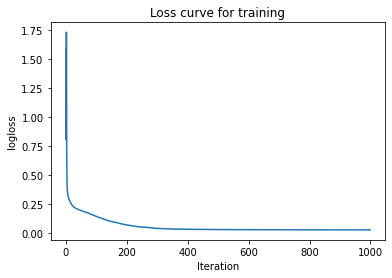

In [ ]:
nn = NN(layers=[13,7,1], learning_rate=0.01, iterations=1000) #create NN model
nn.fit(Xtrain, ytrain)
nn.plot_loss()

testing phase

In [ ]:
train_pred = nn.predict(Xtrain)
test_pred = nn.predict(Xtest)

print("Train accuracy is {} %".format(nn.cal_acc(ytrain, train_pred)))
print("Test accuracy is {} %".format(nn.cal_acc(ytest, test_pred)))

Train accuracy is 98 %
Test accuracy is 74 %
